# Customer Clustering Feature Analysis

This notebook fetches customer clustering features from DuckDB, analyzes correlations, selects K best features, and performs UMAP projection for visualization.

In [4]:
# Import Required Libraries
# Install compatible versions of umap-learn, numpy, and scipy
import sys
import subprocess

def pip_install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    import umap
    import numpy as np
    import scipy
    from packaging import version
    if version.parse(np.__version__) > version.parse('2.2.6'):
        print(f"Downgrading numpy from {np.__version__} to 2.2.6 for umap-learn compatibility...")
        pip_install('numpy==2.2.6')
    if version.parse(scipy.__version__) < version.parse('1.0.0'):
        print(f"Upgrading scipy from {scipy.__version__} to >=1.0.0 for umap-learn compatibility...")
        pip_install('scipy>=1.0.0')
except ImportError:
    print("Installing umap-learn, numpy==2.2.6, and scipy>=1.0.0...")
    pip_install('umap-learn')
    pip_install('numpy==2.2.6')
    pip_install('scipy>=1.0.0')

print("If you see errors about numpy/scipy/umap, restart the kernel and rerun this cell.")
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
import warnings

warnings.filterwarnings('ignore')

Installing umap-learn, numpy==2.2.6, and scipy>=1.0.0...
If you see errors about numpy/scipy/umap, restart the kernel and rerun this cell.


## Connect to DuckDB and Load Features Data

Connect to the DuckDB database and load the customer clustering features table into a pandas DataFrame.

In [5]:
# Connect to DuckDB and load features table
db_file = 'customer_features.db'
features_table = 'customer_clustering_features'
conn = duckdb.connect(db_file)
df = conn.execute(f"SELECT * FROM {features_table}").df()
print(f"Loaded {df.shape[0]:,} rows and {df.shape[1]:,} columns.")

Loaded 1,844,880 rows and 27 columns.


## Explore Data: Summary Statistics and Missing Values

Display summary statistics, check for missing values, and show the first few rows of the features DataFrame.

In [6]:
# Show summary statistics and missing values
display_cols = [col for col in df.columns if df[col].dtype != 'O']
print("Summary statistics:")
display(df[display_cols].describe().T)
print("\nMissing values per column:")
display(df.isnull().sum())
print("\nFirst 5 rows:")
display(df.head())

Summary statistics:


,count,mean,min,25%,50%,75%,max,std
SALES_ORDER_NO_nunique,1844880.0,197.994889,11.0,39.0,86.0,190.0,6822.0,452.669296
SKU_nunique,1844880.0,499.422133,1.0,98.0,221.0,502.0,6729.0,908.297399
ITEMS_RETURNED_COUNT,1844880.0,149841.08669,0.0,500.0,3344.0,23517.0,13323510.0,904838.163434
SALES_QTY_mean,1844880.0,1.13738,1.0,1.036697,1.074324,1.145946,103.733333,0.521888
AVG_ORDER_SIZE,1844880.0,3.0788,1.0,1.942029,2.566667,3.554622,19.340426,1.859982
RETURN_RATE,1844880.0,0.266895,0.0,0.100619,0.238095,0.405229,1.666667,0.198095
RETURN_RATIO,1844880.0,0.241939,0.0,0.09304,0.21608,0.369369,0.928,0.175792
RETURN_PRODUCT_VARIETY,1844880.0,165.392429,0.0,12.0,42.0,136.0,3990.0,441.544082
AVG_RETURNS_PER_ORDER,1844880.0,748.598755,0.0,27.308641,100.666664,378.0,44451.039062,3608.722168
RETURN_FREQUENCY_RATIO,1844880.0,197.991806,0.0,18.923077,60.76923,182.757492,4020.398682,469.482849



Missing values per column:


CUSTOMER_EMAILID                     0
SALES_ORDER_NO_nunique               0
SKU_nunique                          0
ITEMS_RETURNED_COUNT                 0
SALES_QTY_mean                       0
AVG_ORDER_SIZE                       0
RETURN_RATE                          0
RETURN_RATIO                         0
RETURN_PRODUCT_VARIETY               0
AVG_RETURNS_PER_ORDER                0
RETURN_FREQUENCY_RATIO               0
RETURN_INTENSITY                     0
CONSECUTIVE_RETURNS                  0
AVG_CONSECUTIVE_RETURNS              0
CUSTOMER_LIFETIME_DAYS               0
CUSTOMER_TENURE_STAGE                0
first_order_date                     0
last_order_date                      0
AVG_DAYS_TO_RETURN               57249
RETURN_TIMING_SPREAD            102343
RECENT_ORDERS                        0
RECENT_RETURNS                  249710
SKU_ADJACENCY_ORDERS           1844880
SKU_ADJACENCY_RETURNS          1844880
SKU_ADJACENCY_TIMING           1844880
SKU_ADJACENCY_RETURN_TIMI


First 5 rows:


,CUSTOMER_EMAILID,SALES_ORDER_NO_nunique,SKU_nunique,ITEMS_RETURNED_COUNT,SALES_QTY_mean,AVG_ORDER_SIZE,RETURN_RATE,RETURN_RATIO,RETURN_PRODUCT_VARIETY,AVG_RETURNS_PER_ORDER,...,last_order_date,AVG_DAYS_TO_RETURN,RETURN_TIMING_SPREAD,RECENT_ORDERS,RECENT_RETURNS,SKU_ADJACENCY_ORDERS,SKU_ADJACENCY_RETURNS,SKU_ADJACENCY_TIMING,SKU_ADJACENCY_RETURN_TIMING,Q_CLS_ID
0,allietumminia@gmail.com,35,243,2695.0,1.008130,7.028571,0.313008,0.310484,77,541.200012,...,2025-06-18 19:28:21,7.883117,4.183218,4,11.0,<NA>,<NA>,<NA>,<NA>,4000004
1,hannareb@yahoo.com,50,272,650.0,1.110294,5.740000,0.047794,0.043046,13,70.720001,...,2025-06-22 12:29:46,24.461538,24.962022,4,0.0,<NA>,<NA>,<NA>,<NA>,14400003
2,mindy_s_jensen@msn.com,205,643,29110.0,1.070769,3.346341,0.218462,0.204023,138,450.243896,...,2025-06-22 11:13:48,41.880282,60.855541,40,15.0,<NA>,<NA>,<NA>,<NA>,1800007
3,adriana.cudny@gmail.com,26,51,208.0,1.019608,2.000000,0.156863,0.153846,8,15.692307,...,2025-02-14 01:02:14,8.125000,3.270539,0,NaN,<NA>,<NA>,<NA>,<NA>,2700002
4,juliettequang@yahoo.com,212,272,8904.0,1.179487,1.509434,0.153846,0.130435,42,54.084908,...,2025-05-25 14:12:01,18.857143,38.645715,9,2.0,<NA>,<NA>,<NA>,<NA>,13300001


## Compute Feature Correlations

Calculate the correlation matrix for the features and visualize it using a heatmap.

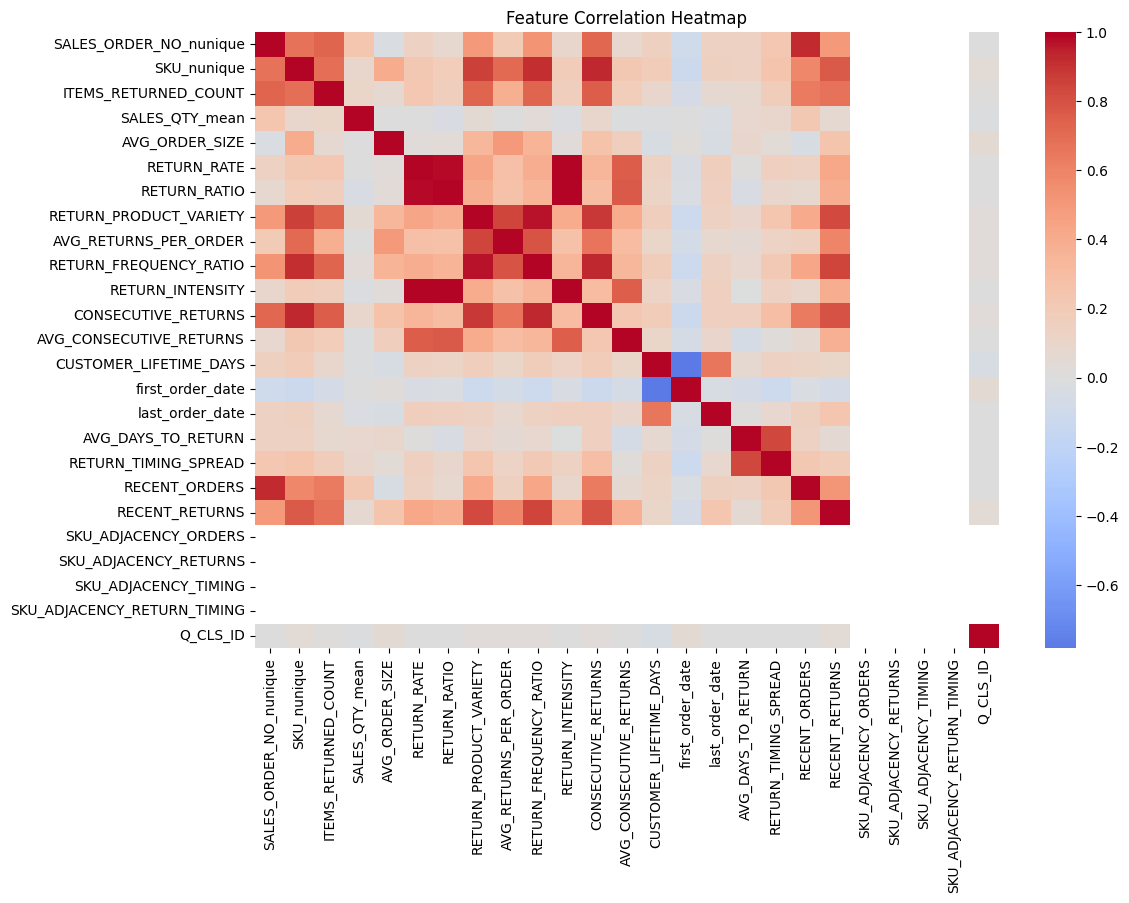

In [7]:
# Compute and plot correlation heatmap
corr = df[display_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

## Select K Best Features using sklearn

Use sklearn's SelectKBest to select the top K features. By default, K=5.

In [8]:
# Select K Best features (K=5 by default)
from sklearn.feature_selection import SelectKBest, f_classif

# For demonstration, use a dummy target (e.g., total items returned > median)
if 'ITEMS_RETURNED_COUNT' in df.columns:
    y = (df['ITEMS_RETURNED_COUNT'] > df['ITEMS_RETURNED_COUNT'].median()).astype(int)
else:
    y = np.random.randint(0, 2, size=len(df))

X = df[display_cols].fillna(0)
K = 5
selector = SelectKBest(score_func=f_classif, k=K)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()]
print(f"Top {K} features by SelectKBest:")
print(selected_features.tolist())

TypeError: Cannot cast DatetimeArray to dtype float64

## UMAP Projection for Visualization

Apply UMAP to the feature set for dimensionality reduction and visualize the projection in 2D using a scatter plot.

In [ ]:
# UMAP projection on selected features
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X[selected_features])
plt.figure(figsize=(8,6))
plt.scatter(X_umap[:,0], X_umap[:,1], s=10, alpha=0.7)
plt.title('UMAP Projection of Customer Features')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

In [ ]:
# Ensure compatible versions for umap-learn/numba
!pip install numpy==2.2.6 scipy>=1.0.0 --quiet
# After running this cell, restart the kernel and rerun the notebook if you see import errors.

In [ ]:
# Install compatible versions of umap-learn, numpy, and scipy
import sys
import subprocess

def pip_install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    import umap
    import numpy as np
    import scipy
    from packaging import version
    if version.parse(np.__version__) > version.parse('2.2.6'):
        print(f"Downgrading numpy from {np.__version__} to 2.2.6 for umap-learn compatibility...")
        pip_install('numpy==2.2.6')
    if version.parse(scipy.__version__) < version.parse('1.0.0'):
        print(f"Upgrading scipy from {scipy.__version__} to >=1.0.0 for umap-learn compatibility...")
        pip_install('scipy>=1.0.0')
except ImportError:
    print("Installing umap-learn, numpy==2.2.6, and scipy>=1.0.0...")
    pip_install('umap-learn')
    pip_install('numpy==2.2.6')
    pip_install('scipy>=1.0.0')

print("If you see errors about numpy/scipy/umap, restart the kernel and rerun this cell.")

In [ ]:
# Install compatible versions of umap-learn, numpy, and scipy
import sys
import subprocess

def pip_install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    import umap
    import numpy as np
    import scipy
    from packaging import version
    if version.parse(np.__version__) > version.parse('2.2.6'):
        print(f"Downgrading numpy from {np.__version__} to 2.2.6 for umap-learn compatibility...")
        pip_install('numpy==2.2.6')
    if version.parse(scipy.__version__) < version.parse('1.0.0'):
        print(f"Upgrading scipy from {scipy.__version__} to >=1.0.0 for umap-learn compatibility...")
        pip_install('scipy>=1.0.0')
except ImportError:
    print("Installing umap-learn, numpy==2.2.6, and scipy>=1.0.0...")
    pip_install('umap-learn')
    pip_install('numpy==2.2.6')
    pip_install('scipy>=1.0.0')

print("If you see errors about numpy/scipy/umap, restart the kernel and rerun this cell.")